# CNA GHCNh Investigation

Look at trends in the Global Historical Climatology Network hourly (GHCNh) database for the Central US.

In [1]:
import sys
import os
sys.path.append('../')
from setup import CWD, SCRATCH_DIR, FIG_DIR, DATA_DIR

import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from rich import print

def add_latlon(ax):
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}

Load data. Remember times are in Central Standard Time (CST, -6 UTC). If there are multiple hourly measurements, we take the mean. 

In [2]:
GHCNh_file = os.path.join(SCRATCH_DIR, 'GHCNh_cna.parquet')
schema = {
    'Station_ID': pl.String,
    'Station_name': pl.String,
    'time': pl.Datetime(),
    'wind_speed': pl.Float32,
    'wind_direction': pl.Float32,
    'Latitude': pl.Float32,
    'Longitude': pl.Float32,
}
df = (
    pl.scan_parquet(GHCNh_file, schema=schema)
    # Only want full years
    .filter(pl.col('time').dt.year() >= 1979)
    .filter(pl.col('time').dt.year() <= 2024)
    # Latitudes and things can be slightly off so *only* group by Station_ID
    .group_by_dynamic('time', every='1h', group_by='Station_ID').agg([
        pl.col(['Station_name', 'Latitude', 'Longitude']).first(), 
        pl.col(['wind_speed', 'wind_direction']).mean(),
    ])
    .sort('time')
)

metadata = (
    df
    .select(['Station_ID','Station_name', 'Latitude', 'Longitude'])
    # Only determine uniqueness from 'Station_ID'
    .unique(subset='Station_ID', keep='first') # setting `keep='first'` ensures reproducibility
    .collect()
)
# One station has wrong metadata, manually go in and fix
metadata = metadata.with_columns(
    # Schriever Air Force Base, CO
    Longitude=pl.when(pl.col('Longitude') == -121.1).then(-104.5).otherwise(pl.col('Longitude'))
)
# ensure that no station is duplicate
assert metadata['Station_ID'].is_duplicated().sum() == 0
metadata

Station_ID,Station_name,Latitude,Longitude
str,str,f32,f32
"""USW00053905""","""SHREVEPORT DWTN AP""",32.5397,-93.746101
"""USW00013940""","""GREAT BEND MUNI AP""",38.349998,-98.866699
"""USW00013934""","""ENGLAND AFB""",31.3167,-92.550003
"""USI0000KEZP""","""EAST CAMERON 321A AWOS III""",28.219999,-92.794601
"""USW00053966""","""MID WAY RGNL AP""",32.4561,-96.912498
…,…,…,…
"""USW00012947""","""COTULLA LA SALLE CO AP""",28.458599,-99.222801
"""USL000HIST2""","""HIGH ISLAND""",29.594999,-94.389999
"""USW00000244""","""SHIP SHOAL OIL PLATFORM""",28.6,-91.199997


## Plot total number of samples by year

Realistically should put this plot after I have a final dataset

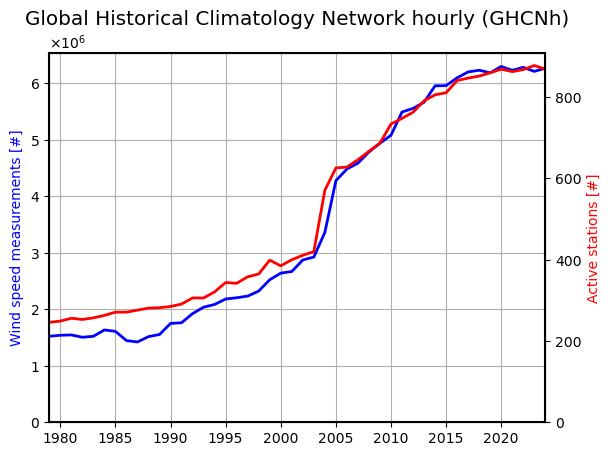

In [3]:
fig, ax = plt.subplots()
year_samples = df.group_by_dynamic('time', every='1y').agg(records=pl.col('wind_speed').len()).collect()
stations_per_year = df.group_by_dynamic('time', every='1y').agg(records=pl.col('Station_ID').unique().len()).collect()

ax.plot(year_samples['time'], year_samples['records'], color='b', lw=2)
ax.grid()
ax.set_ylim(0, None)
ax.set_xlim(year_samples['time'][0], year_samples['time'][-1])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_ylabel('Wind speed measurements [#]', color='b')
ax.set_title('Global Historical Climatology Network hourly (GHCNh)', fontsize='x-large')

ax2 = ax.twinx()
ax2.plot(stations_per_year['time'], stations_per_year['records'], color='r', lw=2)
ax2.set_ylabel('Active stations [#]', color='r')
ax2.set_ylim(0, None)
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

plt.savefig(os.path.join(FIG_DIR, 'GHCNh_number_of_raw_records.png'), dpi=300)
plt.show()

## Filter dataframe to stations with a consistent record
To count as a valid day: `>= 4 measurements`

To count as a valid month: `>= 14 valid days`

To count as a valid year: `12 valid months`

In [4]:
good_years = (
    df
    .group_by_dynamic('time', every='1d', group_by='Station_ID')
    .agg(day_obs=pl.col('wind_speed').len())
    .filter(pl.col('day_obs') >= 4) # remove bad days
    # Cascade into months
    .group_by_dynamic('time', every='1mo', group_by='Station_ID')
    .agg(month_obs=pl.col('day_obs').len())
    .filter(pl.col('month_obs') >= 14) # remove bad months
    # Cascade into years
    .group_by_dynamic('time', every='1y', group_by='Station_ID')
    .agg(year_obs=pl.col('month_obs').len())
    .filter(pl.col('year_obs') == 12) # remove bad years
    .collect()
)
# Now get the number of active years
valid_stations = (
    good_years
    .group_by('Station_ID')
    .agg(num_years=pl.col('year_obs').len())
    .filter(pl.col('num_years') == 46) # 46 is 1979-2024
    .sort(pl.col('num_years'))
)
# Get the total number of records for each station
records_per = df.group_by('Station_ID').agg(num_obs=pl.col('wind_speed').len()).collect()
records_per_year = df.group_by_dynamic('time', every='1y', group_by='Station_ID').agg(num_obs=pl.col('wind_speed').len()).collect()

# Join with the station data
valid_stations = valid_stations.join(records_per, how='left', on='Station_ID')
good_years = (
    good_years
    .filter(pl.col('Station_ID').is_in(valid_stations['Station_ID'].to_numpy()))
    .join(records_per_year, how='left', on=['Station_ID', 'time'])
)

print('good_years', good_years.head()) # has yearly stats
print('valid_stations', valid_stations.head()) # has summary stats
print(f'Number of valid stations: {len(valid_stations)}')

good_years shape: (5, 4)
┌─────────────┬─────────────────────┬──────────┬─────────┐
│ Station_ID  ┆ time                ┆ year_obs ┆ num_obs │
│ ---         ┆ ---                 ┆ ---      ┆ ---     │
│ str         ┆ datetime[μs]        ┆ u32      ┆ u32     │
╞═════════════╪═════════════════════╪══════════╪═════════╡
│ CAN05010481 ┆ 1979-01-01 00:00:00 ┆ 12       ┆ 8352    │
│ CAN05010481 ┆ 1980-01-01 00:00:00 ┆ 12       ┆ 8784    │
│ CAN05010481 ┆ 1981-01-01 00:00:00 ┆ 12       ┆ 8760    │
│ CAN05010481 ┆ 1982-01-01 00:00:00 ┆ 12       ┆ 8760    │
│ CAN05010481 ┆ 1983-01-01 00:00:00 ┆ 12       ┆ 8760    │
└─────────────┴─────────────────────┴──────────┴─────────┘

valid_stations shape: (5, 3)
┌─────────────┬───────────┬─────────┐
│ Station_ID  ┆ num_years ┆ num_obs │
│ ---         ┆ ---       ┆ ---     │
│ str         ┆ u32       ┆ u32     │
╞═════════════╪═══════════╪═════════╡
│ USW00093058 ┆ 46        ┆ 331499  │
│ USW00013961 ┆ 46        ┆ 359638  │
│ USW00012911 ┆ 46        ┆ 346700  │
│ USW00013935 ┆ 46        ┆ 214842  │
│ USW00023042 ┆ 46        ┆ 389895  │
└─────────────┴───────────┴─────────┘

Number of valid stations: 118

### Plot this

Median # of observations: 7911.0, averages out to 21.67 per day (assuming 365 days per year)

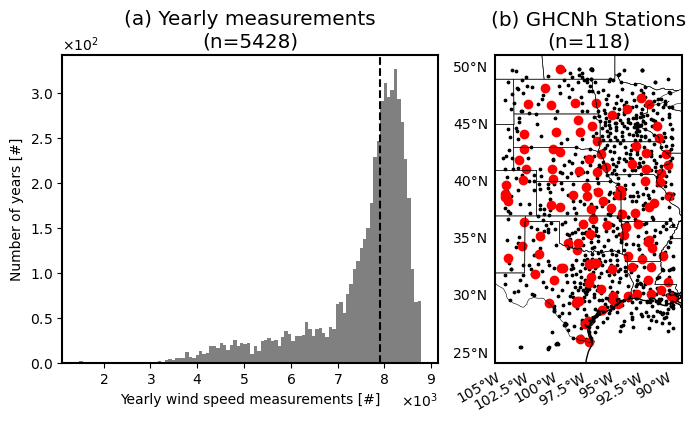

In [5]:
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(ncols=2, width_ratios=[2,1])

# Plot 1: Years of Valid Record
ax = fig.add_subplot(gs[0])
ax.hist(good_years['num_obs'], bins=100, color='gray')
# mean_obs = int(good_years['num_obs'].mean())
median = round(good_years['num_obs'].median(), 1)
print(f'Median # of observations: {median}, averages out to {round(median/365, 2)} per day (assuming 365 days per year)')
ax.axvline(median, color='k', linestyle='dashed')
# txt = f'Mean # of yearly measurements: {mean_obs}\nMean # of measurements/day: {round(mean_obs/365, 1)}'
# ax.text(0.35, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.set_xlabel('Yearly wind speed measurements [#]')
ax.set_ylabel('Number of years [#]')
ax.set_title(f'(a) Yearly measurements\n(n={len(good_years)})', fontsize='x-large')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Plot all stations then selected stations
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.scatter(metadata['Longitude'], metadata['Latitude'], transform=ccrs.PlateCarree(), c='k', s=3)
metadata_filtered = metadata.filter(pl.col('Station_ID').is_in(valid_stations['Station_ID'].to_numpy()))
ax.scatter(metadata_filtered['Longitude'], metadata_filtered['Latitude'], transform=ccrs.PlateCarree(), c='r')
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
add_latlon(ax)
ax.set_title(f'(b) GHCNh Stations\n(n={len(metadata_filtered)})', fontsize='x-large')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_valid_stations.png'), dpi=300)
plt.show()

## Look at mean trends

We want to quantify changes to CNA mean wind speeds. Below are some thoughts.

- Hurricane season in the Atlantic is June through the end of November
- The GPLLJ is mainly a nocturnal, summertime phenomenon
- Any diurnal cycles would relate to heating at the surface, potentially the reduction in static stability proposed by Morris et al. (2023, 24, 25)
- Zeng et al. (2019) sees "global stilling" decrease of -0.08 m/s/decade
- Pryor et a. (2007): "the relative trends are larger for 50th percentile wind speeds than the 90th percentile" -> decreases are less pronounced at high wind speeds
- Also from Pryor et al. (2007):
> Short-term reverse trends are observed in the 50th percentile wind speed at a total of 79 stations in the data set of 157 sites. Sixty-one stations that overall exhibit declining trends, also have statistically significant positive trends over a component of the time series of greater or equal to one decade in duration.

In [6]:
good_IDs = valid_stations['Station_ID'].to_numpy()

### Function to reduce data to monthly given variable numbers of daily measurements

In [7]:
def make_monthly(df, good_IDs):
    agg_spec = [
            pl.col(['wind_speed', 'wind_direction']).mean(),
        ]
        # Define a function to map month to season
    def month_to_season(month):
        if month in [12, 1, 2]:
            return "DJF"  # Winter
        elif month in [3, 4, 5]:
            return "MAM"  # Spring
        elif month in [6, 7, 8]:
            return "JJA"  # Summer
        else:
            return "SON"  # Autumn
    new_df = (
        df
        .filter(pl.col('Station_ID').is_in(good_IDs))
        # Want to get monthly average on a per station basis
        .group_by_dynamic('time', every='1d', group_by='Station_ID').agg(agg_spec)
        .group_by_dynamic('time', every='1mo', group_by='Station_ID').agg(agg_spec)
        .with_columns([
            pl.col('time').dt.month().map_elements(month_to_season).alias('season')
        ])
        .sort('time')
    )
    return new_df

df_mo = make_monthly(df, good_IDs).collect()
df_mo

/tmp/ipykernel_3587871/1990160147.py:28: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_mo = make_monthly(df, good_IDs).collect()


Station_ID,time,wind_speed,wind_direction,season
str,datetime[μs],f32,f32,str
"""CAN05010481""",1979-01-01 00:00:00,4.040845,22.642473,"""DJF"""
"""USI0000KBRO""",1979-01-01 00:00:00,5.233332,210.263992,"""DJF"""
"""USI0000KLCH""",1979-01-01 00:00:00,5.082012,193.837997,"""DJF"""
"""USW00003904""",1979-01-01 00:00:00,5.088584,214.105469,"""DJF"""
"""USW00003919""",1979-01-01 00:00:00,5.616114,231.962662,"""DJF"""
…,…,…,…,…
"""USW00094908""",2024-12-01 00:00:00,4.82688,207.052216,"""DJF"""
"""USW00094910""",2024-12-01 00:00:00,4.667172,220.655945,"""DJF"""
"""USW00094931""",2024-12-01 00:00:00,3.731497,239.025742,"""DJF"""


We now perform a Mann-Kendall test to test for monotonic decreases to windspeed

From [PNNL](https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm)

> The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert 1987) is to statistically assess if there is a monotonic upward or downward trend of the variable of interest over time. A monotonic upward (downward) trend means that the variable consistently increases (decreases) through time, but the trend may or may not be linear. The MK test can be used in place of a parametric linear regression analysis, which can be used to test if the slope of the estimated linear regression line is different from zero. The regression analysis requires that the residuals from the fitted regression line be normally distributed; an assumption not required by the MK test, that is, the MK test is a non-parametric (distribution-free) test.


In [8]:
from sklearn.linear_model import LinearRegression
import pymannkendall as mk
yearly = df_mo.group_by_dynamic('time', every='1y').agg([
    pl.col('wind_speed').mean().alias('wind_mean'),
    (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
])
x = yearly['time'].dt.year().to_numpy()
y = yearly['wind_mean'].to_numpy()
# Perform a Mann-Kendall test to see if there is a monotonic decreasing or increasing trend
result = mk.original_test(y, alpha=0.01)
print(result)
print(f'Decadal slope: {result.slope*10}')

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(0.001564945111822924),
    z=np.float64(-3.1623627045916476),
    Tau=np.float64(-0.32367149758454106),
    s=np.float64(-335.0),
    var_s=11155.0,
    slope=np.float64(-0.004336481509001359),
    intercept=np.float64(4.597227988035782)
)

Decadal slope: -0.04336481509001359

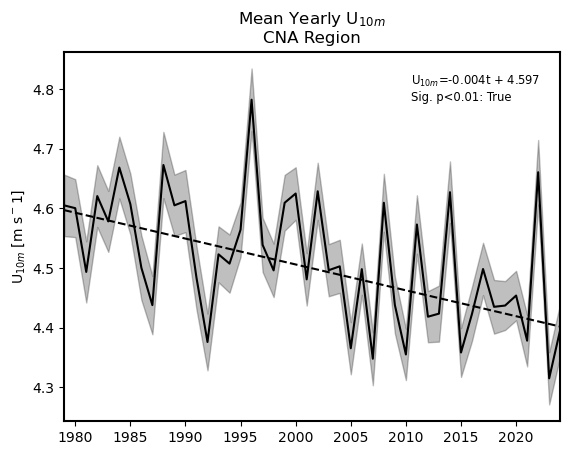

In [9]:
fig, ax = plt.subplots()
# y = y-np.mean(y[:5])
err = yearly['wind_stderr'].to_numpy()*1.96 # z-score for 95%
ax.plot(x, y, color='k')
ax.fill_between(x, y-err, y+err, color='k', alpha=0.25)
# regress
new_y = result.intercept+result.slope*(x-1979)
ax.plot(x, new_y, color='k', linestyle='dashed')
txt='U$_{10m}$='+str(round(result.slope, 3))+'t + '+str(round(result.intercept, 3))+f'\nSig. p<0.01: {result.h}'
ax.text(0.7, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_xlim(x[0], x[-1])
ax.set_ylabel('U$_{10m}$ [m s$^-1$]')
ax.set_title('Mean Yearly U$_{10m}$\nCNA Region')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_yearly_U10m.png'), dpi=300)
plt.show()

DJF

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.066236258090552),
    z=np.float64(-1.836821451169999),
    Tau=np.float64(-0.18840579710144928),
    s=np.float64(-195.0),
    var_s=11155.0,
    slope=np.float64(-0.0042447249094645185),
    intercept=np.float64(4.703109383583069)
)

Decadal slope: -0.04244724909464519

MAM

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.15554283622459053),
    z=np.float64(-1.4202227715231952),
    Tau=np.float64(-0.14589371980676327),
    s=np.float64(-151.0),
    var_s=11155.0,
    slope=np.float64(-0.0031003952026367188),
    intercept=np.float64(5.067920923233032)
)

Decadal slope: -0.031003952026367188

JJA

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(0.01985030801700427),
    z=np.float64(-2.32916534529804),
    Tau=np.float64(-0.23864734299516907),
    s=np.float64(-247.0),
    var_s=11155.0,
    slope=np.float64(-0.003533970225941051),
    intercept=np.float64(4.210143631154841)
)

Decadal slope: -0.03533970225941051

SON

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(1.8722561638151447e-05),
    z=np.float64(-4.279604618189895),
    Tau=np.float64(-0.43768115942028984),
    s=np.float64(-453.0),
    var_s=11155.0,
    slope=np.float64(-0.006185448688009511),
    intercept=np.float64(4.4666252550871475)
)

Decadal slope: -0.06185448688009511

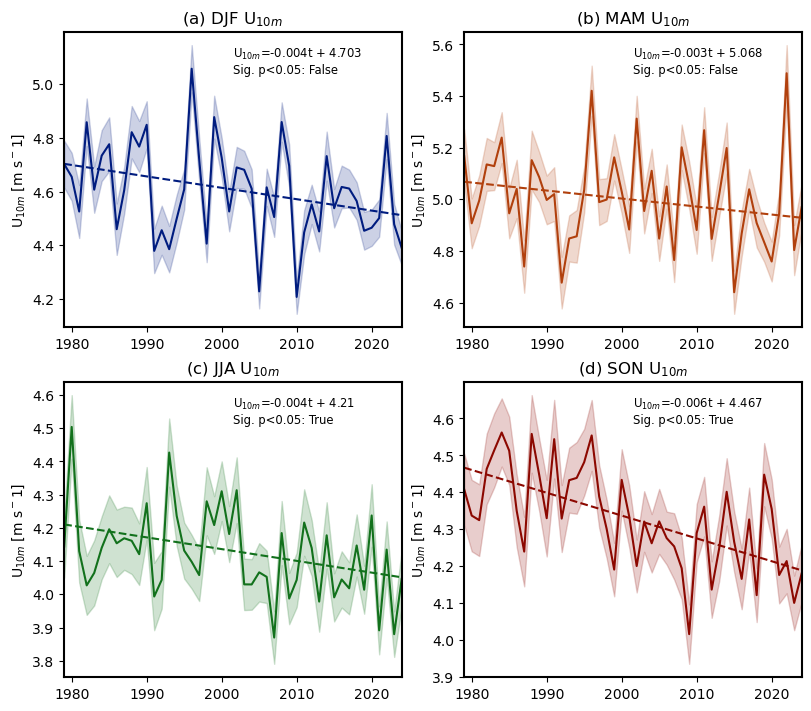

In [10]:
from string import ascii_lowercase
import seaborn as sns
import itertools

palette = itertools.cycle(sns.color_palette('dark'))

fig = plt.figure(figsize=(8,7), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = fig.add_subplot(gs[i])
    s_yearly = (
        df_mo
        .filter(pl.col('season') == season)
        .group_by_dynamic('time', every='1y').agg([
            pl.col('wind_speed').mean().alias('wind_mean'),
            (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
        ])
    )
    x = s_yearly['time'].dt.year().to_numpy()
    y = s_yearly['wind_mean'].to_numpy()
    c = next(palette)
    # y = y-np.mean(y)
    err = s_yearly['wind_stderr'].to_numpy()*1.96 # z-score for 95%
    ax.plot(x, y, color=c)
    ax.fill_between(x, y-err, y+err, alpha=0.2, color=c)
    # Perform a Mann-Kendall test to see if there is a monotonic decreasing or increasing trend
    result = mk.original_test(y, alpha=0.05)
    print('\n\n'+season)
    print(result)
    print(f'Decadal slope: {result.slope*10}')
    new_y = result.intercept+result.slope*(x-1979)
    ax.plot(x, new_y, color=c, linestyle='dashed')
    txt='U$_{10m}$='+str(round(result.slope, 3))+'t + '+str(round(result.intercept, 3))+f'\nSig. p<0.05: {result.h}'
    ax.text(0.5, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('U$_{10m}$ [m s$^-1$]')
    ax.set_title(f'({ascii_lowercase[i]}) {season}'+' U$_{10m}$')
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_yearly_U10m_by_season.png'), dpi=300)
plt.show()

### Split into daytime and nocturnal

Day is `[06, 18)`, night is `[18, 06]` (recall this data is in CST). Filter by day because night goes till the next day so it gets tricky.

In [11]:
def make_monthly_diurnal(df, good_IDs):
    agg_spec = [
            pl.col(['wind_speed', 'wind_direction']).mean(),
        ]
        # Define a function to map month to season
    def month_to_season(month):
        if month in [12, 1, 2]:
            return "DJF"  # Winter
        elif month in [3, 4, 5]:
            return "MAM"  # Spring
        elif month in [6, 7, 8]:
            return "JJA"  # Summer
        else:
            return "SON"  # Autumn
    new_df = (
        df
        .filter(pl.col('Station_ID').is_in(good_IDs))
        # Add a column for day (times are in CST)
        .with_columns(
            day = (pl.col('time').dt.hour() >= 6) & (pl.col('time').dt.hour() < 18)
        )
        # Want to get monthly average on a per station basis
        .group_by_dynamic('time', every='1d', group_by=['Station_ID', 'day']).agg(agg_spec)
        .group_by_dynamic('time', every='1mo', group_by=['Station_ID', 'day']).agg(agg_spec)
        .with_columns([
            pl.col('time').dt.month().map_elements(month_to_season).alias('season')
        ])
        .sort('time')
    )
    return new_df

df_mod = make_monthly_diurnal(df, good_IDs).collect()
df_mod

/tmp/ipykernel_3587871/2546206077.py:32: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_mod = make_monthly_diurnal(df, good_IDs).collect()


Station_ID,day,time,wind_speed,wind_direction,season
str,bool,datetime[μs],f32,f32,str
"""CAN05010481""",false,1979-01-01 00:00:00,4.001643,23.11828,"""DJF"""
"""CAN05010481""",true,1979-01-01 00:00:00,4.080048,22.166666,"""DJF"""
"""USI0000KBRO""",false,1979-01-01 00:00:00,4.796292,199.97702,"""DJF"""
"""USI0000KBRO""",true,1979-01-01 00:00:00,5.644269,219.587738,"""DJF"""
"""USI0000KLCH""",false,1979-01-01 00:00:00,4.910814,190.338715,"""DJF"""
…,…,…,…,…,…
"""USW00094931""",true,2024-12-01 00:00:00,3.858337,237.440338,"""DJF"""
"""USW00094938""",false,2024-12-01 00:00:00,3.839559,235.223938,"""DJF"""
"""USW00094938""",true,2024-12-01 00:00:00,3.972662,221.36998,"""DJF"""


day

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.21837532925140546),
    z=np.float64(-1.2308597353201025),
    Tau=np.float64(-0.12657004830917876),
    s=np.float64(-131.0),
    var_s=11155.0,
    slope=np.float64(-0.0013439995901925223),
    intercept=np.float64(4.940817764827183)
)

Decadal slope: -0.013439995901925222

night

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(4.194152906755733e-06),
    z=np.float64(-4.601521779735152),
    Tau=np.float64(-0.47053140096618357),
    s=np.float64(-487.0),
    var_s=11155.0,
    slope=np.float64(-0.006250775378683339),
    intercept=np.float64(4.1735604223997695)
)

Decadal slope: -0.06250775378683339

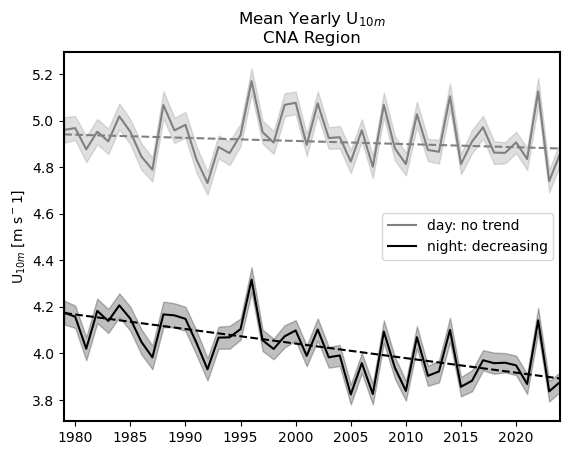

In [12]:
yearly_diurnal = df_mod.group_by_dynamic('time', every='1y', group_by='day').agg([
    pl.col('wind_speed').mean().alias('wind_mean'),
    (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
])
x = yearly['time'].unique().dt.year().to_numpy()
fig, ax = plt.subplots()
for time in ['day', 'night']:
    if time == 'day':
        c = 'gray'
        y = yearly_diurnal.filter(pl.col('day') == True)['wind_mean'].to_numpy()
        err = yearly_diurnal.filter(pl.col('day') == True)['wind_stderr'].to_numpy()*1.96 # z-score for 95%
    else:
        c = 'black'
        y = yearly_diurnal.filter(pl.col('day') == False)['wind_mean'].to_numpy()
        err = yearly_diurnal.filter(pl.col('day') == False)['wind_stderr'].to_numpy()*1.96 # z-score 95%
    # Perform a Mann-Kendall test to see if there is a monotonic decreasing or increasing trend
    print(time)
    result = mk.original_test(y, alpha=0.01)
    print(result)
    print(f'Decadal slope: {result.slope*10}')
    new_y = result.intercept+result.slope*(x-1979)
    ax.plot(x, new_y, color=c, linestyle='dashed')
    txt='U$_{10m}$='+str(round(result.slope, 3))+'t + '+str(round(result.intercept, 3))+f'\nSig. p<0.01: {result.h}'
    ax.plot(x, y, color=c, label=time+': '+result.trend)
    ax.fill_between(x, y-err, y+err, color=c, alpha=0.25)
    #ax.text(0.7, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_xlim(x[0], x[-1])
ax.set_ylabel('U$_{10m}$ [m s$^-1$]')
ax.set_title('Mean Yearly U$_{10m}$\nCNA Region')
ax.legend()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_yearly_U10m_diurnal.png'), dpi=300)
plt.show()

### Now look at diurnal trends for each season

DJFday

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.2255416917319515),
    z=np.float64(-1.211923431699793),
    Tau=np.float64(-0.1246376811594203),
    s=np.float64(-129.0),
    var_s=11155.0,
    slope=np.float64(-0.0024510622024536133),
    intercept=np.float64(4.976050913333893)
)

Decadal slope: -0.024510622024536133

DJFnight

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.051123784784707915),
    z=np.float64(-1.9504392728918547),
    Tau=np.float64(-0.2),
    s=np.float64(-207.0),
    var_s=11155.0,
    slope=np.float64(-0.003929429584079319),
    intercept=np.float64(4.2889708280563354)
)

Decadal slope: -0.039294295840793185

MAMday

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.42642461891641004),
    z=np.float64(0.7953247520529892),
    Tau=np.float64(0.0821256038647343),
    s=np.float64(85.0),
    var_s=11155.0,
    slope=np.float64(0.0020086581890399638),
    intercept=np.float64(5.442930753414448)
)

Decadal slope: 0.02008658189039964

MAMnight

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(0.00802342387614563),
    z=np.float64(-2.6510825068432977),
    Tau=np.float64(-0.2714975845410628),
    s=np.float64(-281.0),
    var_s=11155.0,
    slope=np.float64(-0.006176695227622986),
    intercept=np.float64(4.544514916837215)
)

Decadal slope: -0.06176695227622986

JJAday

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.7909260715569881),
    z=np.float64(0.26510825068432975),
    Tau=np.float64(0.028019323671497585),
    s=np.float64(29.0),
    var_s=11155.0,
    slope=np.float64(0.0002868864271375868),
    intercept=np.float64(4.47815465927124)
)

Decadal slope: 0.0028688642713758676

JJAnight

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(9.375574921755003e-06),
    z=np.float64(-4.431095047152369),
    Tau=np.float64(-0.45314009661835747),
    s=np.float64(-469.0),
    var_s=11155.0,
    slope=np.float64(-0.006691435972849528),
    intercept=np.float64(3.793131023645401)
)

Decadal slope: -0.06691435972849528

SONday

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(0.003998017092012418),
    z=np.float64(-2.8783181502870088),
    Tau=np.float64(-0.2946859903381642),
    s=np.float64(-305.0),
    var_s=11155.0,
    slope=np.float64(-0.004221765618575246),
    intercept=np.float64(4.847182938927098)
)

Decadal slope: -0.04221765618575246

SONnight

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(2.038165218287702e-05),
    z=np.float64(-4.260668314569585),
    Tau=np.float64(-0.4357487922705314),
    s=np.float64(-451.0),
    var_s=11155.0,
    slope=np.float64(-0.006917592250939571),
    intercept=np.float64(3.9756772301413794)
)

Decadal slope: -0.06917592250939572

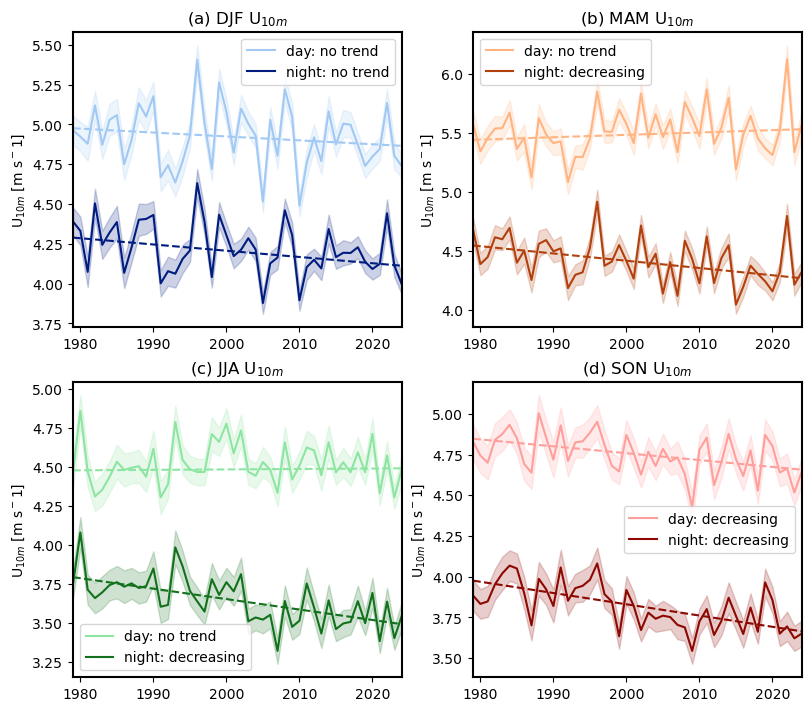

In [13]:
day_palette = itertools.cycle(sns.color_palette('pastel'))
night_palette = itertools.cycle(sns.color_palette('dark'))

fig = plt.figure(figsize=(8,7), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = fig.add_subplot(gs[i])
    s_yearly = (
        df_mod
        .filter(pl.col('season') == season)
        .group_by_dynamic('time', every='1y', group_by='day').agg([
            pl.col('wind_speed').mean().alias('wind_mean'),
            (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
        ])
    )
    x = s_yearly['time'].unique().dt.year().to_numpy()
    for time in ['day', 'night']:
        if time == 'day':
            c = next(day_palette)
            y = s_yearly.filter(pl.col('day') == True)['wind_mean'].to_numpy()
            err = s_yearly.filter(pl.col('day') == True)['wind_stderr'].to_numpy()*1.96 # z-score for 95%
        else:
            c = next(night_palette)
            y = s_yearly.filter(pl.col('day') == False)['wind_mean'].to_numpy()
            err = s_yearly.filter(pl.col('day') == False)['wind_stderr'].to_numpy()*1.96 # z-score 95%
        # Perform a Mann-Kendall test to see if there is a monotonic decreasing or increasing trend
        result = mk.original_test(y, alpha=0.05)
        print('\n\n'+season+time)
        print(result)
        print(f'Decadal slope: {result.slope*10}')
        new_y = result.intercept+result.slope*(x-1979)
        ax.plot(x, new_y, color=c, linestyle='dashed')

        ax.plot(x, y, color=c, label=time+': '+result.trend)
        ax.fill_between(x, y-err, y+err, alpha=0.2, color=c)
        ax.legend()
    # txt='U$_{10m}$='+str(round(result.slope, 3))+'t + '+str(round(result.intercept, 3))+f'\nSig. p<0.05: {result.h}'
    # ax.text(0.5, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('U$_{10m}$ [m s$^-1$]')
    ax.set_title(f'({ascii_lowercase[i]}) {season}'+' U$_{10m}$')
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_yearly_U10m_by_season_diurnal.png'), dpi=300)
plt.show()

## Compare to surface !!! historical CMIP6 !!! Data

### Load CMIP6 historical data

Overview of experiments at [https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_experiment_id.html](https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_experiment_id.html)

In [23]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [15]:
# Can also use from xmip.utils import google_cmip_col
import intake
import dask
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [16]:
from xmip.preprocessing import combined_preprocessing


# Historical query
query = dict(
    experiment_id=['historical'],
    table_id=['day'],
    variable_id=['uas', 'vas', 'ua', 'va', 'psl'], # added pressure at sea level
    member_id=['r1i1p1f1'],
)
### CHANGE THIS NAME BASED ON QUERY PARAMETERS ###
CMIP6_FILE = os.path.join(SCRATCH_DIR, 'CMIP6historical_day.nc')
print(CMIP6_FILE)
##################################################

if not os.path.exists(CMIP6_FILE):
    cat_data = col.search(require_all_on='source_id', **query)
    z_kwargs = {'consolidated': True, 'decode_times':True}
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        dset_dict = cat_data.to_dataset_dict(zarr_kwargs=z_kwargs,
                                        preprocess=combined_preprocessing)
    def model_name(key):
        return key.split('.')[2]
    model_names = [model_name(k) for k in dset_dict.keys()]
    print(model_names)

/scratch/valencig/GPLLJ-Scratch/CMIP6historical_day.nc

In [17]:
# Subset the CNA
import pandas as pd
import xarray as xr
from tqdm import tqdm
import regionmask

if not os.path.exists(CMIP6_FILE):
    grid_da = xr.load_dataset(os.path.join(DATA_DIR, 'CNA_grid.nc'))
    dsets = []
    models = []
    # Station data starts at 1979
    for key in tqdm(dset_dict.keys()):
        if key == 'CMIP.NOAA-GFDL.GFDL-CM4.historical.day.gr1': # no ('ua', 'va')
            continue
        # CMIP6 historical code
        # Station data starts at 1979
        ds = dset_dict[key]
        subset = (
            ds
            .convert_calendar('standard', use_cftime=False, align_on='year') # 'year': This option is best used for daily/subdaily
            .sel(time=slice('1979', '2014'))
            # Wind speed on surface
            .assign(sfcWind=lambda x: np.sqrt(x['uas']**2 + x['vas']**2))
            # Wind speed on pressure levels
            .assign(pWind=lambda x: np.sqrt(x['ua']**2 + x['va']**2))
            .interp_like(grid_da, method='linear') # clips and regrids
            .squeeze()
        ).compute()
        ### mask to only land 
        land = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(subset.x, subset.y)
        subset = subset.where(land == 0, drop=True)
        # Ensure there are no weird issues where things are nan everywhere
        if subset.sfcWind.max() >= 0:
            dsets.append(subset)
            models.append(key)
        else:
            print(key)
    # Save file
    ds = xr.concat(dsets, pd.Index([m.split('.')[2] for m in models], name='source_id'), coords='minimal', compat='override') # override to ignore `lat_bounds`
    ds.to_netcdf(CMIP6_FILE)

In [ ]:
# from dask.distributed import LocalCluster
# cluster = LocalCluster()          # Fully-featured local Dask cluster
# client = cluster.get_client()

In [24]:
# Now load
ds = xr.open_dataset(CMIP6_FILE, chunks='auto')
ds

<xarray.Dataset> Size: 103GB
Dimensions:         (source_id: 21, time: 13149, plev: 8, y: 52, x: 32,
                     bnds: 2, vertex: 4)
Coordinates: (12/15)
  * plev            (plev) float32 32B 1e+05 8.5e+04 7e+04 ... 1e+04 5e+03 1e+03
  * time            (time) datetime64[ns] 105kB 1979-01-01T12:00:00 ... 2014-...
  * y               (y) float64 416B 25.0 25.5 26.0 26.5 ... 49.0 49.5 50.0 50.5
  * x               (x) float64 256B 255.0 255.5 256.0 ... 269.5 270.0 270.5
    time_bounds     (time, bnds) datetime64[ns] 210kB dask.array<chunksize=(13149, 2), meta=np.ndarray>
    lon             (x, y) float64 13kB dask.array<chunksize=(32, 52), meta=np.ndarray>
    ...              ...
    height          float64 8B ...
    lon_bounds      (x, bnds, y) float64 27kB dask.array<chunksize=(32, 2, 52), meta=np.ndarray>
    lat_bounds      (y, bnds, x) float64 27kB dask.array<chunksize=(52, 2, 32), meta=np.ndarray>
    lon_verticies   (vertex, x, y) float64 53kB dask.array<chunksize=(4, 32, 52), meta=np.ndarray>
    lat_verticies   (vertex, x, y) float64 53kB dask.array<chunksize=(4, 32, 52), meta=np.ndarray>
  * source_id       (source_id) <U17 1kB 'IPSL-CM6A-LR' ... 'IITM-ESM'
Dimensions without coordinates: bnds, vertex
Data variables:
    ua              (source_id, time, plev, y, x) float64 29GB dask.array<chunksize=(7, 6303, 2, 19, 10), meta=np.ndarray>
    uas             (source_id, time, y, x) float64 4GB dask.array<chunksize=(9, 6514, 22, 13), meta=np.ndarray>
    va              (source_id, time, plev, y, x) float64 29GB dask.array<chunksize=(7, 6303, 2, 19, 10), meta=np.ndarray>
    vas             (source_id, time, y, x) float64 4GB dask.array<chunksize=(9, 6514, 22, 13), meta=np.ndarray>
    psl             (source_id, time, y, x) float64 4GB dask.array<chunksize=(9, 6514, 22, 13), meta=np.ndarray>
    sfcWind         (source_id, time, y, x) float64 4GB dask.array<chunksize=(9, 6514, 22, 13), meta=np.ndarray>
    pWind           (source_id, time, plev, y, x) float64 29GB dask.array<chunksize=(7, 6303, 2, 19, 10), meta=np.ndarray>
Attributes: (12/57)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            historical
    NCO:                              "4.6.0"
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20180803
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.historical.day.gr

### Perform Mann-Kendall tests on CMIP6 historical Mean and station data

All with $\alpha=0.05$.

In [25]:
# CMIP6 historical only has data through 2014
df_2014 = yearly.filter(pl.col('time').dt.year() <= 2014)
print(df_2014['time'].dt.year().unique())

# Station data (suffix `_s`)
x = df_2014['time'].dt.year().to_numpy()
y_s = df_2014['wind_mean'].to_numpy()
yerr_s = df_2014['wind_stderr'].to_numpy()*1.96 # z-score for 95%
print('Station Data')
result_s = mk.original_test(y_s, alpha=0.05)
print(result_s)

# CMIP6 historical data (suffix `_a`)
weights = np.cos(np.deg2rad(ds.y))
spatial_avg = ds.sfcWind.weighted(weights).mean(['x', 'y']).resample(time='1YE').mean().compute()
all_mean = spatial_avg.mean('source_id')
all_stderr = spatial_avg.std('source_id')/np.sqrt(len(ds.source_id))
# x_a = all_mean.time.to_numpy()
y_a = all_mean.to_numpy()
yerr_a = all_stderr.to_numpy() * 1.96 # z for 95% C.I.
print('\n\nCMIP6 historical Mean')
result_a = mk.original_test(y_a, alpha=0.05)
print(result_a)

shape: (36,)
Series: 'time' [i32]
[
        1979
        1980
        1981
        1982
        1983
        …
        2010
        2011
        2012
        2013
        2014
]

Station Data

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.05831741573896787),
    z=np.float64(-1.8933042843591046),
    Tau=np.float64(-0.2222222222222222),
    s=np.float64(-140.0),
    var_s=5390.0,
    slope=np.float64(-0.003946526845296224),
    intercept=np.float64(4.600147088368733)
)

[########################################] | 100% Completed | 5.54 sms
[########################################] | 100% Completed | 5.64 s


CMIP6 historical Mean

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(2.983293529323916e-06),
    z=np.float64(-4.671966687303402),
    Tau=np.float64(-0.546031746031746),
    s=np.float64(-344.0),
    var_s=5390.0,
    slope=np.float64(-0.0022612363559198494),
    intercept=np.float64(3.5029197201559947)
)

#### Plot

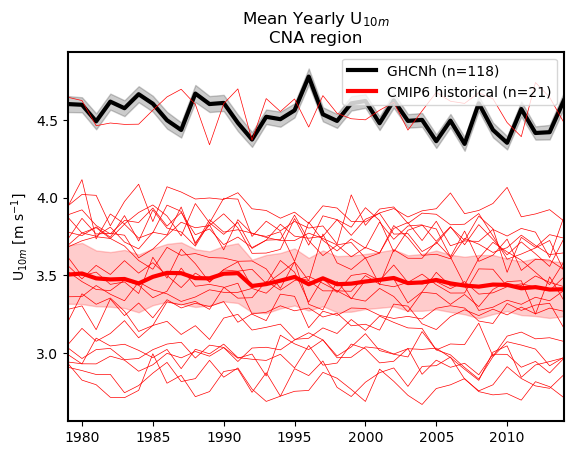

In [26]:
fig, ax = plt.subplots()
# Plot station data
ax.plot(x, y_s, color='k', linewidth=3, label=f'GHCNh (n={len(metadata_filtered)})')
ax.fill_between(x, y_s-yerr_s, y_s+yerr_s, color='k', alpha=0.2)
# new_y_s = result_s.intercept + result_s.slope*np.arange(len(x)) # From Mann-Kendall test
#ax.plot(x, new_y_s, color='k', linestyle='dashed')

# Plot CMIP6 historical
ax.plot(x, y_a, color='r', linewidth=3, label=f'CMIP6 historical (n={len(ds.source_id)})')
ax.fill_between(x, y_a-yerr_a, y_a+yerr_a, color='r', alpha=0.2)
# new_y_a = result_a.intercept + result_a.slope*np.arange(len(x)) # From Mann-Kendall test
#ax.plot(x, new_y_a, color='r', linestyle='dashed')

# Plot members
for source_id in ds.source_id.to_numpy():
    wind = spatial_avg.sel(source_id=source_id).to_numpy()
    # ref_wind = wind - np.mean(wind) + np.mean(y_a)
    ax.plot(x, wind, color='r', linewidth=0.5)

# Equation from yearly station_data
ax.set_xlim(x[0], x[-1])
ax.set_ylabel('U$_{10m}$ [m s$^{-1}$]')
ax.set_title('Mean Yearly U$_{10m}$\nCNA region')
ax.legend()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_CMIP6historical_cna_yearly.png'), dpi=300)
plt.show()

#### Mann-Kendall test for each model

In [27]:
results = dict(
    source_id=[],
    trend=[],
    h=[],
    p=[],
    z=[],
    Tau=[],
    s=[],
    var_s=[],
    slope=[],
    intercept=[]
)
for source_id in ds.source_id.to_numpy():
    model_da = spatial_avg.sel(source_id=source_id)
    wind = model_da.to_numpy()
    res = mk.original_test(wind, alpha=0.05)
    results['source_id'].append(source_id)
    results['trend'].append(res.trend)
    results['h'].append(res.h)
    results['p'].append(res.p)
    results['z'].append(res.z)
    results['Tau'].append(res.Tau)
    results['s'].append(res.s)
    results['var_s'].append(res.var_s)
    results['slope'].append(res.slope)
    results['intercept'].append(res.intercept)

df_mk = pl.from_dict(results).sort('slope')
df_mk.write_csv(os.path.join(DATA_DIR, 'mann-kendall-tests/CMIP6historical_day_yearly.csv'), float_precision=5)
df_mk

source_id,trend,h,p,z,Tau,s,var_s,slope,intercept
str,str,bool,f64,f64,f64,f64,f64,f64,f64
"""MPI-ESM1-2-LR""","""decreasing""",true,0.000378,-3.555053,-0.415873,-262.0,5390.0,-0.006061,3.556839
"""CanESM5""","""decreasing""",true,0.004417,-2.846767,-0.333333,-210.0,5390.0,-0.005956,3.941257
"""AWI-ESM-1-1-LR""","""decreasing""",true,0.02831,-2.192964,-0.257143,-162.0,5390.0,-0.004183,3.836548
"""EC-Earth3""","""decreasing""",true,0.007906,-2.656074,-0.311111,-196.0,5390.0,-0.003515,3.807568
"""EC-Earth3-Veg-LR""","""decreasing""",true,0.009279,-2.601591,-0.304762,-192.0,5390.0,-0.003357,3.825813
…,…,…,…,…,…,…,…,…,…
"""MIROC6""","""no trend""",false,0.653079,-0.44949,-0.053968,-34.0,5390.0,-0.000579,2.85887
"""INM-CM5-0""","""no trend""",false,0.92404,-0.095346,-0.012698,-8.0,5390.0,-0.000109,3.389936
"""INM-CM4-8""","""no trend""",false,0.967405,0.040863,0.006349,4.0,5390.0,0.00004,3.434989


#### Plot

Red (blue) is statistically signifigant increase (decrease) at $\alpha=0.05$.

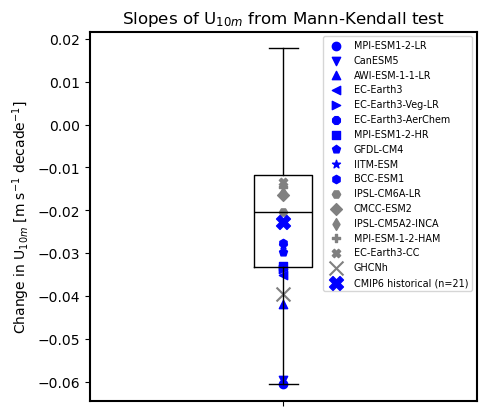

In [29]:
slopes = df_mk['slope'].to_numpy()*10
trends = df_mk['trend'].to_numpy()
source_ids = df_mk['source_id'].to_numpy()
filled_markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'][:len(slopes)]
fig, ax = plt.subplots(figsize=(5, 4.8))
box_plot = ax.boxplot(slopes, showfliers=False)
box_plot['medians'][0].set_color('black')
for slope, trend, source_id, marker in zip(slopes, trends, source_ids, filled_markers):
    if trend == 'increasing':
        ax.scatter(1, slope, marker=marker, color='r', label=source_id)
    elif trend == 'no trend': 
        ax.scatter(1, slope, marker=marker, color='gray', label=source_id)
    elif trend == 'decreasing':
        ax.scatter(1, slope, marker=marker, color='blue', label=source_id)
# Now plot station data
ax.scatter(1, result_s.slope*10, marker='x', color='gray', s=100, label='GHCNh')
# Now plot CMIP6 historical data
ax.scatter(1, result_a.slope*10, marker='X', color='blue', s=100, label=f'CMIP6 historical (n={len(ds.source_id)})')
ax.legend()
ax.set_xticklabels('')
ax.set_ylabel('Change in U$_{10m}$ [m s$^{-1}$ decade$^{-1}$]')
ax.set_title('Slopes of U$_{10m}$ from Mann-Kendall test')
plt.legend(fontsize='x-small')
for spine in ax.spines.values():
        spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_CMIP6historical_cna_yearly_mk_boxplot.png'), dpi=300)
plt.show()

### Now look at seasonal changes

In [39]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return "DJF"  # Winter
    elif month in [3, 4, 5]:
        return "MAM"  # Spring
    elif month in [6, 7, 8]:
        return "JJA"  # Summer
    else:
        return "SON"  # Autumn
df_a_mon = (
    pl.from_pandas(
        ds.sfcWind
        .weighted(weights).mean(['x','y'])
        .to_dataframe()
        .reset_index()
    )
    .sort('time')
    .group_by_dynamic('time', every='1mo', group_by='source_id').agg([
            pl.col('sfcWind').mean()
    ])
    .with_columns([
            pl.col('time').dt.month().map_elements(month_to_season).alias('season')
        ])
    .sort('time')
)
df_a_mon

[########################################] | 100% Completed | 4.92 sms
[########################################] | 100% Completed | 4.92 s


/tmp/ipykernel_3587871/2257043811.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns([


source_id,time,sfcWind,season
str,datetime[ns],f64,str
"""MIROC6""",1979-01-01 00:00:00,2.879378,"""DJF"""
"""CanESM5""",1979-01-01 00:00:00,3.759629,"""DJF"""
"""BCC-ESM1""",1979-01-01 00:00:00,3.678979,"""DJF"""
"""GFDL-CM4""",1979-01-01 00:00:00,3.346452,"""DJF"""
"""IITM-ESM""",1979-01-01 00:00:00,3.320901,"""DJF"""
…,…,…,…
"""AWI-ESM-1-1-LR""",2014-12-01 00:00:00,3.809044,"""DJF"""
"""IPSL-CM5A2-INCA""",2014-12-01 00:00:00,3.555568,"""DJF"""
"""MPI-ESM-1-2-HAM""",2014-12-01 00:00:00,3.109152,"""DJF"""


In [31]:
# Make station data seasonal
station_seasonal = make_monthly(df.filter(pl.col('time').dt.year() <= 2014), good_IDs).collect()
station_seasonal

/tmp/ipykernel_3587871/2073129931.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  station_seasonal = make_monthly(df.filter(pl.col('time').dt.year() <= 2014), good_IDs).collect()


Station_ID,time,wind_speed,wind_direction,season
str,datetime[μs],f32,f32,str
"""CAN05010481""",1979-01-01 00:00:00,4.040845,22.642473,"""DJF"""
"""USI0000KBRO""",1979-01-01 00:00:00,5.233332,210.263992,"""DJF"""
"""USI0000KLCH""",1979-01-01 00:00:00,5.082012,193.837997,"""DJF"""
"""USW00003904""",1979-01-01 00:00:00,5.088584,214.105469,"""DJF"""
"""USW00003919""",1979-01-01 00:00:00,5.616114,231.962662,"""DJF"""
…,…,…,…,…
"""USW00094908""",2014-12-01 00:00:00,4.560596,194.257187,"""DJF"""
"""USW00094910""",2014-12-01 00:00:00,4.255556,210.376373,"""DJF"""
"""USW00094931""",2014-12-01 00:00:00,3.562544,234.512405,"""DJF"""


#### Plot

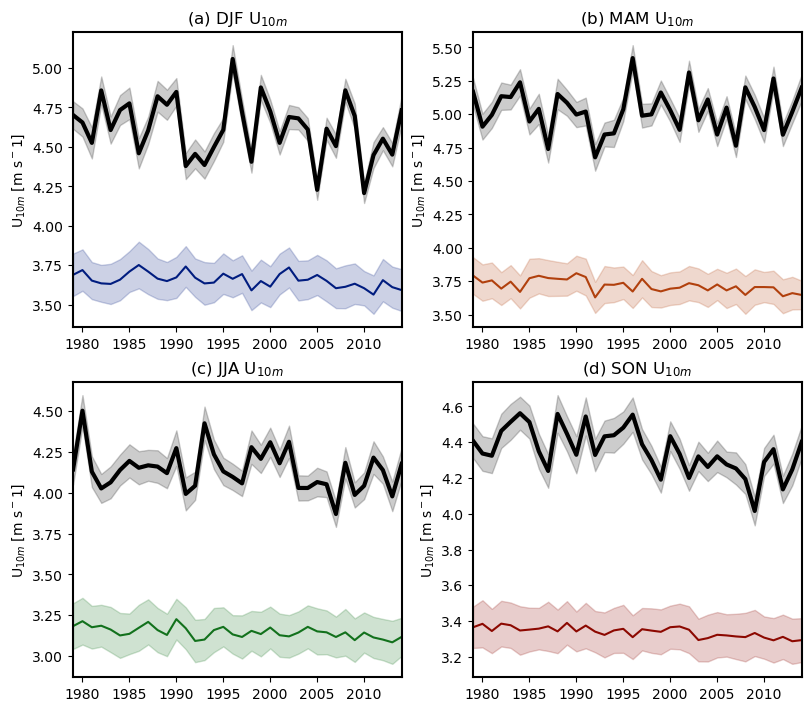

In [40]:
palette = itertools.cycle(sns.color_palette('dark'))

fig = plt.figure(figsize=(8,7), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = fig.add_subplot(gs[i])

    # Plot station wind
    station_winds = (
        station_seasonal
        .filter(pl.col('season') == season)
        .group_by_dynamic('time', every='1y').agg([
            pl.col('wind_speed').mean().alias('wind_mean'),
            (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
        ])
    )
    station_wind = station_winds['wind_mean'].to_numpy()
    station_err = station_winds['wind_stderr'].to_numpy() * 1.96 # z-score for 95%
    ax.plot(x, station_wind, linewidth=3, color='k')
    ax.fill_between(x, station_wind-station_err, station_wind+station_err, alpha=0.2, color='k')

    # Mann-Kendall Test for stations
    # print('\n\n'+season)
    # print(mk.original_test(station_wind, alpha=0.05))

    # Plot models
    s_yearly = (
        df_a_mon
        .filter(pl.col('season') == season)
        .group_by_dynamic('time', every='1y').agg([
            pl.col('sfcWind').mean().alias('sfcWind_mean'),
            (pl.col('sfcWind').std()/np.sqrt(pl.col('sfcWind').len())).alias('sfcWind_stderr')
        ])
    )
    x = s_yearly['time'].dt.year().to_numpy()
    y = s_yearly['sfcWind_mean'].to_numpy()
    c = next(palette)
    # y = y-np.mean(y) + np.mean(station_wind)
    err = s_yearly['sfcWind_stderr'].to_numpy()*1.96 # z-score for 95%
    ax.plot(x, y, color=c)
    ax.fill_between(x, y-err, y+err, alpha=0.2, color=c)
    
    # Perform a Mann-Kendall test to see if there is a monotonic decreasing or increasing trend
    # result = mk.original_test(y, alpha=0.05)
    # print('\n\n'+season)
    # print(result)
    # print(f'Decadal slope: {result.slope*10}')
    # new_y = result.intercept+result.slope*(x-1979)
    # ax.plot(x, new_y, color=c, linestyle='dashed')
    # txt='U$_{10m}$='+str(round(result.slope, 3))+'t + '+str(round(result.intercept, 3))+f'\nSig. p<0.05: {result.h}'
    # ax.text(0.5, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    # Cosmetic
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('U$_{10m}$ [m s$^-1$]')
    ax.set_title(f'({ascii_lowercase[i]}) {season}'+' U$_{10m}$')
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_CMIP6historical_cna_seasonal_U10m.png'), dpi=300)
plt.show()

#### Mann-Kendall test

In [42]:
results = dict(
    source_id=[],
    season=[],
    trend=[],
    h=[],
    p=[],
    z=[],
    Tau=[],
    s=[],
    var_s=[],
    slope=[],
    intercept=[]
)
for source_id in ds.source_id.to_numpy():
    for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        ax = fig.add_subplot(gs[i])
        wind = (
            df_a_mon.filter(pl.col('source_id') == source_id)
            .filter(pl.col('season') == season)
            .select('sfcWind')
        )
        res = mk.original_test(wind, alpha=0.05)
        results['source_id'].append(source_id)
        results['season'].append(season)
        results['trend'].append(res.trend)
        results['h'].append(res.h)
        results['p'].append(res.p)
        results['z'].append(res.z)
        results['Tau'].append(res.Tau)
        results['s'].append(res.s)
        results['var_s'].append(res.var_s)
        results['slope'].append(res.slope)
        results['intercept'].append(res.intercept)
df_mk_season = pl.from_dict(results)
df_mk_season.write_csv(os.path.join(DATA_DIR, 'mann-kendall-tests/CMIP6historical_day_seasonal.csv'), float_precision=5)
df_mk_season

source_id,season,trend,h,p,z,Tau,s,var_s,slope,intercept
str,str,str,bool,f64,f64,f64,f64,f64,f64,f64
"""IPSL-CM6A-LR""","""DJF""","""no trend""",false,0.178303,-1.345998,-0.08792,-508.0,141882.0,-0.001591,3.386623
"""IPSL-CM6A-LR""","""MAM""","""no trend""",false,0.405996,-0.830961,-0.054344,-314.0,141882.0,-0.001154,3.358356
"""IPSL-CM6A-LR""","""JJA""","""no trend""",false,0.498418,0.676981,0.044306,256.0,141882.0,0.000474,2.075
"""IPSL-CM6A-LR""","""SON""","""no trend""",false,0.215048,-1.239805,-0.080997,-468.0,141882.0,-0.001143,2.487563
"""IPSL-CM5A2-INCA""","""DJF""","""no trend""",false,0.115415,-1.574313,-0.102804,-594.0,141882.0,-0.001349,3.734876
…,…,…,…,…,…,…,…,…,…,…
"""BCC-ESM1""","""SON""","""no trend""",false,0.068979,-1.818557,-0.118726,-686.0,141882.0,-0.001392,3.875431
"""IITM-ESM""","""DJF""","""no trend""",false,0.930187,-0.087609,-0.005884,-34.0,141882.0,-0.000047,3.432758
"""IITM-ESM""","""MAM""","""no trend""",false,0.050394,-1.956608,-0.127726,-738.0,141882.0,-0.001452,3.780719


#### Plot seasonal Mann-Kendall test

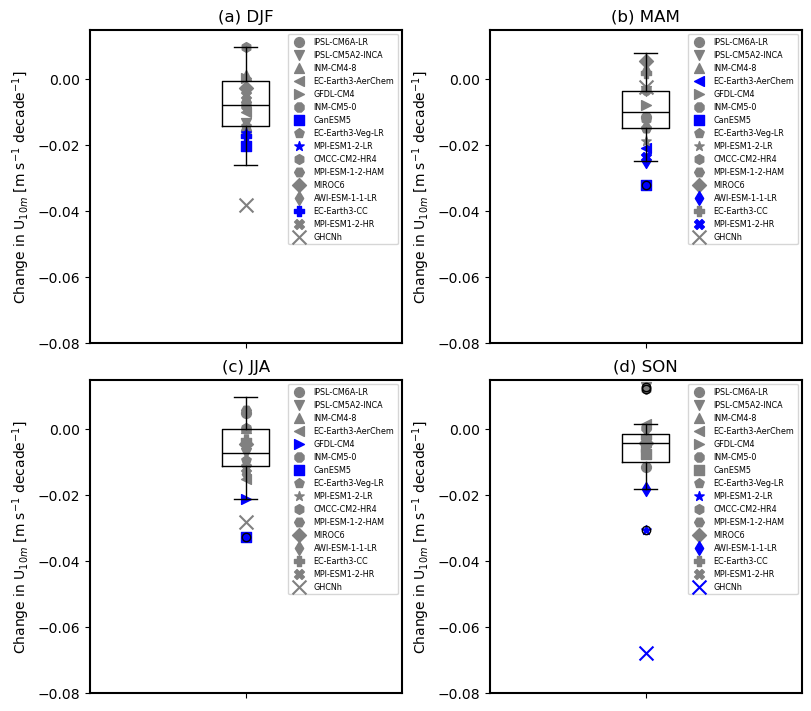

In [44]:
fig = plt.figure(figsize=(8,7), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = fig.add_subplot(gs[i])
    subset = df_mk_season.filter(pl.col('season') == season)
    slopes = subset['slope'].to_numpy()*10
    trends = subset['trend'].to_numpy()
    source_ids = subset['source_id'].to_numpy()
    filled_markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'][:len(slopes)]
    box_plot = ax.boxplot(slopes)
    box_plot['medians'][0].set_color('black')
    for slope, trend, source_id, marker in zip(slopes, trends, source_ids, filled_markers):
        if trend == 'increasing':
            ax.scatter(1, slope, marker=marker, color='r', label=source_id, s=50)
        elif trend == 'no trend': 
            ax.scatter(1, slope, marker=marker, color='gray', label=source_id, s=50)
        elif trend == 'decreasing':
            ax.scatter(1, slope, marker=marker, color='blue', label=source_id, s=50)
    # Now perform test for station data
    station_wind = (
        station_seasonal
        .filter(pl.col('season') == season)
        .group_by_dynamic('time', every='1y')
        .agg(wind_speed = pl.col('wind_speed').mean())
        .select('wind_speed')
    )
    res = mk.original_test(station_wind, alpha=0.1)
    # print('Station Result: '+season)
    # print(res)
    if res.trend == 'increasing':
            ax.scatter(1, res.slope*10, marker='x', color='r', s=100, label='GHCNh')
    elif res.trend == 'no trend': 
        ax.scatter(1, res.slope*10, marker='x', color='gray', s=100, label='GHCNh')
    elif res.trend == 'decreasing':
        ax.scatter(1, res.slope*10, marker='x', color='blue', s=100, label='GHCNh')
    ax.legend()
    ax.set_xticklabels('')
    ax.set_ylabel('Change in U$_{10m}$ [m s$^{-1}$ decade$^{-1}$]')
    plt.legend(fontsize='xx-small')
    ax.set_title(f'({ascii_lowercase[i]}) {season}')
    ax.set_ylim(-0.08, 0.015)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_CMIP6historical_cna_seasonal_mk_boxplot.png'), dpi=300)
plt.show()

## Look at pearson correlation

In [45]:
from scipy.stats import pearsonr
results = dict(
    source_id=[],
    statistic=[],
    pvalue=[],
)

for source_id in ds.source_id.to_numpy():
    model_da = spatial_avg.sel(source_id=source_id)
    wind = model_da.to_numpy()
    statistic, pvalue = pearsonr(y_s, model_da)
    results['source_id'].append(source_id)
    results['statistic'].append(statistic)
    results['pvalue'].append(pvalue)

df_pr = pl.from_dict(results).sort('statistic')
df_pr.write_csv(os.path.join(DATA_DIR, 'pearsonr-tests/CMIP6historical_day_yearly.csv'), float_precision=5)
df_pr

source_id,statistic,pvalue
str,f64,f64
"""CMCC-CM2-HR4""",-0.257285,0.129807
"""MPI-ESM-1-2-HAM""",-0.244676,0.150374
"""BCC-ESM1""",-0.212505,0.213388
"""IPSL-CM6A-LR""",-0.080202,0.641946
"""CMCC-ESM2""",-0.011244,0.948107
…,…,…
"""IPSL-CM5A2-INCA""",0.257467,0.129527
"""MRI-ESM2-0""",0.295899,0.079737
"""GFDL-CM4""",0.340336,0.042252


### Plot 

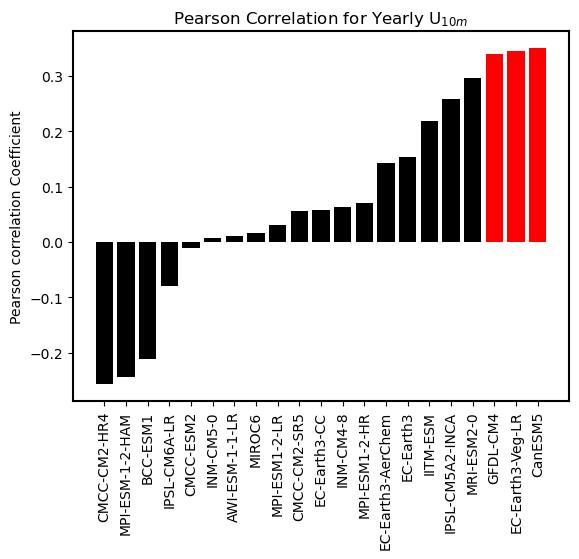

In [47]:
colors = ['red' if p < 0.05 else 'black' for p in df_pr['pvalue']]
fig, ax = plt.subplots()

ax.bar(df_pr['source_id'], df_pr['statistic'], color=colors)
ax.set_ylabel('Pearson correlation Coefficient')
plt.xticks(rotation=90)
ax.set_title('Pearson Correlation for Yearly U$_{10m}$')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_CMIP6historical_cna_yearly_U10m_pearsonr.png'), dpi=300)
plt.show()

## Mode surface wind trends

In [48]:
def yearly_mode(df, good_IDs):
    # Define a function to map month to season
    def month_to_season(month):
        if month in [12, 1, 2]:
            return "DJF"  # Winter
        elif month in [3, 4, 5]:
            return "MAM"  # Spring
        elif month in [6, 7, 8]:
            return "JJA"  # Summer
        else:
            return "SON"  # Autumn
    new_df = (
        df
        .filter(pl.col('Station_ID').is_in(good_IDs))
        # Get mode for each season from good hourly data
        .with_columns([
            pl.col('time').dt.month().map_elements(month_to_season).alias('season')
        ])
        .group_by_dynamic('time', every='1y', group_by=['season', 'Station_ID'])
        # Use `.first()` so we get a float return not an 1 element array
        .agg(pl.col('wind_speed').mode().first().alias('wind_speed_mode'))
        .sort('time')
    )
    return new_df.collect()

df_s_mode = yearly_mode(df.filter(pl.col('time').dt.year() <= 2014), good_IDs)
df_s_mode

/tmp/ipykernel_3587871/3703071913.py:24: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  return new_df.collect()


season,Station_ID,time,wind_speed_mode
str,str,datetime[μs],f32
"""DJF""","""CAN05010481""",1979-01-01 00:00:00,3.055556
"""DJF""","""USI0000KBRO""",1979-01-01 00:00:00,5.1
"""DJF""","""USI0000KLCH""",1979-01-01 00:00:00,5.1
"""DJF""","""USW00003904""",1979-01-01 00:00:00,5.1
"""DJF""","""USW00003919""",1979-01-01 00:00:00,5.2
…,…,…,…
"""SON""","""USW00094908""",2014-01-01 00:00:00,3.6
"""SON""","""USW00094910""",2014-01-01 00:00:00,3.1
"""SON""","""USW00094931""",2014-01-01 00:00:00,1.5


### Function to apply get linear regression and Mann Kendall test

In [72]:
def mk_linear(winds):
    assert len(winds) == (2014-1979)+1
    try:
        mk_test = mk.original_test(winds, alpha=0.05)
        return (mk_test.h, mk_test.p, mk_test.trend, mk_test.slope)
    except: # This handles (x,y) chunks with all nan values
        return (np.nan, np.nan, np.nan, np.nan)

def apply_mk_linear(winds):
    h, p, trend, slope = xr.apply_ufunc(
        mk_linear,
        winds,
        input_core_dims=[['year']],
        output_core_dims=[[], [], [], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[bool, float, str, float],
    )
    return xr.merge([
        h.rename('h'),
        p.rename('p'),
        trend.rename('trend'), 
        slope.rename('slope')
    ])

### Apply linear Mann-Kendall test to station data

In [80]:
station_dict = dict(
    Station_ID=[],
    h=[],
    p=[],
    trend=[],
    slope=[]
)
for station in df_s_mode['Station_ID'].unique():
    # Only get SON data
    winds = (
        df_s_mode
        .filter(pl.col('Station_ID') == station)
        .filter(pl.col('season') == 'SON')
        .select('wind_speed_mode')
        .to_numpy()
    )
    h, p, trend, slope = mk_linear(winds)
    station_dict['Station_ID'].append(station)
    station_dict['h'].append(h)
    station_dict['p'].append(p)
    station_dict['trend'].append(trend)
    station_dict['slope'].append(slope)

station_mode_mk = (
    pl.from_dict(station_dict)
    .join(metadata, how='left', on='Station_ID')
)
# station_mode_mk.write_csv(os.path.join(DATA_DIR, 'mann-kendall-tests/CMIP6historical_day_seasonal.csv'), float_precision=5)
station_mode_mk

Station_ID,h,p,trend,slope,Station_name,Latitude,Longitude
str,bool,f64,str,f64,str,f32,f32
"""USW00094931""",true,0.000206,"""decreasing""",-0.08619,"""HIBBING CHISHOLM HIBBING AP""",47.380299,-92.832497
"""USW00013987""",false,0.439292,"""no trend""",0.0,"""JOPLIN RGNL AP""",37.152199,-94.4953
"""USW00093997""",false,0.055069,"""no trend""",0.0,"""RUSSELL MUNI AP""",38.872501,-98.809196
"""USW00014950""",true,0.000008,"""decreasing""",-0.055556,"""OTTUMWA IND AP""",41.1008,-92.444397
"""USW00012935""",false,0.154992,"""no trend""",-0.02,"""PALACIOS MUNI AP""",28.724701,-96.253601
…,…,…,…,…,…,…,…
"""USW00022010""",true,0.003268,"""increasing""",0.027273,"""DEL RIO INTL AP""",29.3783,-100.926903
"""USW00014936""",false,0.128942,"""no trend""",-0.018188,"""HURON RGNL AP""",44.3792,-98.222801
"""USW00093909""",true,0.000079,"""decreasing""",-0.071429,"""OLATHE JOHNSON CO IND AP""",38.822201,-94.890297


### Apply linear Mann-Kendall test to model data

We need to download daily model data in order to get this information.

In [73]:
from scipy import stats
import warnings


def mode_func(x, axis):
    if np.isnan(x).all():
        return np.nan
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mode_result = stats.mode(x, axis=axis, nan_policy='omit')
        return mode_result.mode

model_ds = []
# Need to do this in a loop to mask out na pixels (models on different native grids)
# want to keep highest resolution possible for each model so no regridding
for source_id in ds.source_id.to_numpy():
    da = (
        ds.sfcWind
        .sel(source_id=source_id)
    ).compute()
    # da_grid = da.where(da >= 0, drop=True)
    da_son = da.sel(time=da.time.dt.month.isin([9, 10, 11]))
    da_mode = da_son.groupby('time.year').reduce(mode_func, dim='time')
    regressed = apply_mk_linear(da_mode).compute()
    model_ds.append(regressed)
mk_models = xr.concat(model_ds, pd.Index(ds.source_id.to_numpy(), name='source_id'), coords='minimal', compat='override')
mk_models

[########################################] | 100% Completed | 403.03 ms
[########################################] | 100% Completed | 503.25 ms
[########################################] | 100% Completed | 402.91 ms
[########################################] | 100% Completed | 502.79 ms
[########################################] | 100% Completed | 504.02 ms
[########################################] | 100% Completed | 603.73 ms
[########################################] | 100% Completed | 402.10 ms
[########################################] | 100% Completed | 402.16 ms
[########################################] | 100% Completed | 402.25 ms
[########################################] | 100% Completed | 402.54 ms
[########################################] | 100% Completed | 402.82 ms
[########################################] | 100% Completed | 502.80 ms
[########################################] | 100% Completed | 402.17 ms
[########################################] | 100% Completed | 40

<xarray.Dataset> Size: 761kB
Dimensions:         (source_id: 21, y: 52, x: 32)
Coordinates:
  * y               (y) float64 416B 25.0 25.5 26.0 26.5 ... 49.0 49.5 50.0 50.5
  * x               (x) float64 256B 255.0 255.5 256.0 ... 269.5 270.0 270.5
    lon             (x, y) float64 13kB 255.0 255.0 255.0 ... 270.5 270.5 270.5
    lat             (x, y) float64 13kB 25.0 25.5 26.0 26.5 ... 49.5 50.0 50.5
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  float64 8B nan
    height          float64 8B 10.0
  * source_id       (source_id) object 168B 'IPSL-CM6A-LR' ... 'IITM-ESM'
Data variables:
    h               (source_id, y, x) bool 35kB False False ... False False
    p               (source_id, y, x) float64 280kB 0.247 0.1689 ... 0.8381
    trend           (source_id, y, x) <U1 140kB 'n' 'n' 'n' 'n' ... 'n' 'n' 'n'
    slope           (source_id, y, x) float64 280kB -0.00101 ... 0.0002881

### Make plot

In [89]:
print(station_mode_mk['slope'].max()*10)
print(station_mode_mk['slope'].min()*10)

0.6222620574376916

-2.0449999570846558

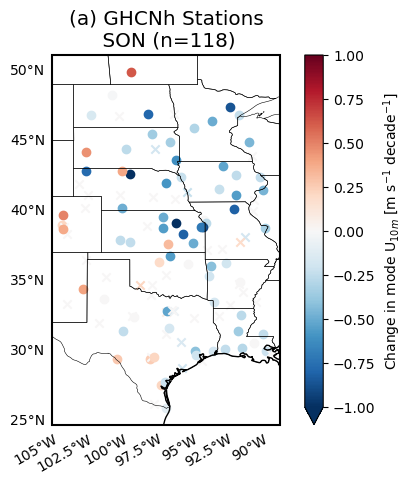

In [91]:
sig_shapes = ['o' if h else 'x' for h in station_mode_mk['h']]
kwargs = {
    'cmap': 'RdBu_r',
    'vmin': -1,
    'vmax': 1
}
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# plot in rows for shape options
for lon, lat, slope, shape in zip(station_mode_mk['Longitude'], station_mode_mk['Latitude'], station_mode_mk['slope'], sig_shapes):
    im = ax.scatter(
        lon, lat,
        c=slope*10,
        marker=shape,
        transform=ccrs.PlateCarree(),
        **kwargs
    )
cbar = fig.colorbar(im, ax=ax, extend='min')
cbar.set_label('Change in mode U$_{10m}$ [m s$^{-1}$ decade$^{-1}$]')
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
add_latlon(ax)
ax.set_title(f'(a) GHCNh Stations\n SON (n={len(metadata_filtered)})', fontsize='x-large')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.show()

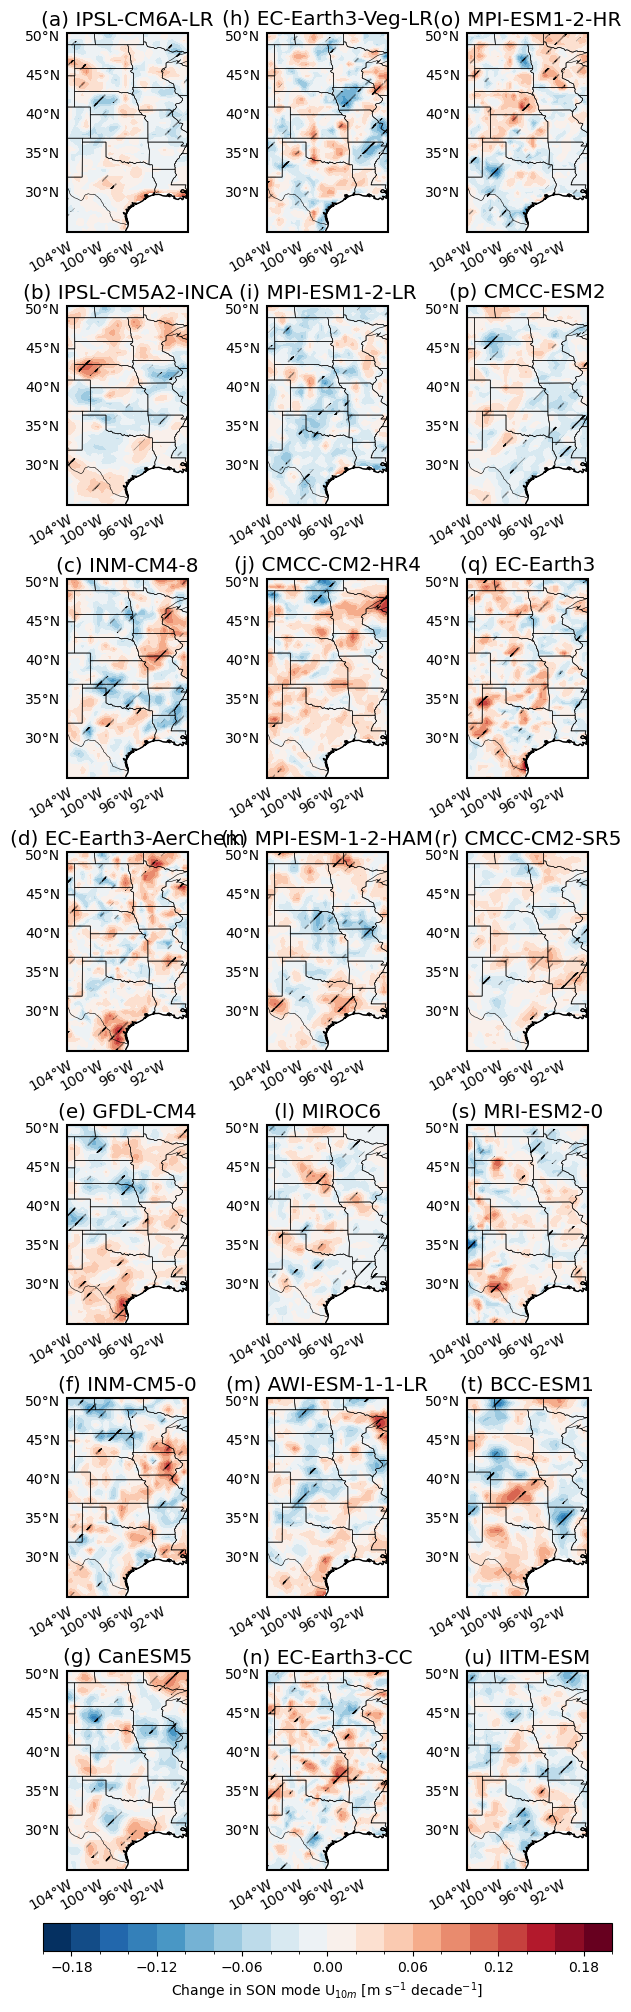

In [98]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
kwargs = {
    'cmap': 'RdBu_r',
    'vmin': -0.2,
    'vmax': 0.2
}
fig = plt.figure(figsize=(6, 20), constrained_layout=True)
gs = fig.add_gridspec(ncols=3, nrows=7)
# Now do every other station
axs = [[], [], [], [], [], [], []]
for i, source_id in enumerate(ds.source_id.to_numpy()):
    row = i % 7
    col = i // 7
    ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
    axs[row].append(ax)
    ###
    subset = mk_models.sel(source_id=source_id)
    latlon = subset.where(~np.isnan(subset.slope), drop=True)
    mask = latlon.h # True where trend is signifigant
    decadal_slope = latlon.slope*10
    im = decadal_slope.plot.contourf(ax=ax, add_colorbar=False, levels=21, transform=ccrs.PlateCarree(), **kwargs)
    # Plot signifigance
    if np.sum(mask) > 0: # masking gets messed up if all 0, it hatches everywhere
        mask.plot.contourf(ax=ax, alpha=0, hatches=["", "//"], add_colorbar=False, levels=21, transform=ccrs.PlateCarree())
    # sig_pts = pl.from_pandas(mask.to_dataframe().reset_index()).filter(pl.col('h') == 1)
    # ax.scatter(sig_pts['x'], sig_pts['y'], transform=ccrs.PlateCarree(), marker='+', color='k', alpha=0.5, s=10)
    ### 
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    add_latlon(ax)
    ax.set_title(f'({ascii_lowercase[i]}) {source_id}', fontsize='x-large')
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

# axins = inset_axes(ax, # here using axis of the lowest plot
#                width="340%",
#                height="10%",
#                loc='upper right',
#                bbox_to_anchor=(1.05, 0.3, 1, 1),
#                bbox_transform=ax.transAxes,
#                borderpad=0,
#                )
axs = np.array(axs)
cbar = plt.colorbar(im, ax=axs[6, :], orientation='horizontal')
cbar.set_label('Change in SON mode U$_{10m}$ [m s$^{-1}$ decade$^{-1}$]')
plt.show()

## Upper level wind

In [ ]:
palette = itertools.cycle(sns.color_palette('dark'))

shape: (36,)
Series: 'time' [i32]
[
        1979
        1980
        1981
        1982
        1983
        …
        2010
        2011
        2012
        2013
        2014
]

Station Data

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.05831741573896787),
    z=np.float64(-1.8933042843591046),
    Tau=np.float64(-0.2222222222222222),
    s=np.float64(-140.0),
    var_s=5390.0,
    slope=np.float64(-0.003946526845296224),
    intercept=np.float64(4.600147088368733)
)

[########################################] | 100% Completed | 29.74 ss
[########################################] | 100% Completed | 29.84 s


CMIP6 historical mean

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(0.001245927910190403),
    z=np.float64(-3.228151909302934),
    Tau=np.float64(-0.37777777777777777),
    s=np.float64(-238.0),
    var_s=5390.0,
    slope=np.float64(-0.00292925436909977),
    intercept=np.float64(7.664915218705805)
)

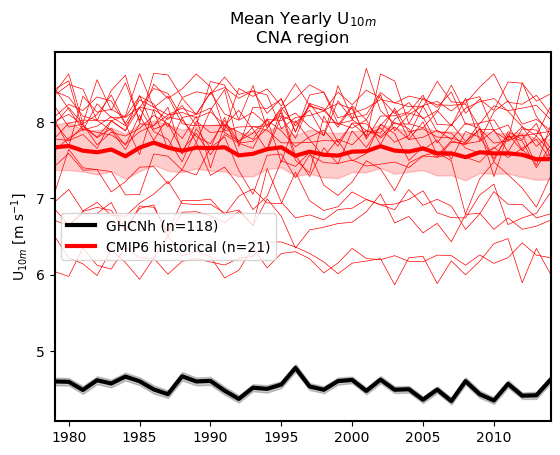

In [105]:
# CMIP6 historical only has data through 2014
df_2014 = yearly.filter(pl.col('time').dt.year() <= 2014)
print(df_2014['time'].dt.year().unique())

# Station data (suffix `_s`)
x = df_2014['time'].dt.year().to_numpy()
y_s = df_2014['wind_mean'].to_numpy()
yerr_s = df_2014['wind_stderr'].to_numpy()*1.96 # z-score for 95%
print('Station Data')
result_s = mk.original_test(y_s, alpha=0.05)
print(result_s)

# CMIP6 historical data (suffix `_a`)
weights = np.cos(np.deg2rad(ds.y))
spatial_avg = ds.pWind.sel(plev=850*100).weighted(weights).mean(['x', 'y']).resample(time='1YE').mean().compute()
all_mean = spatial_avg.mean('source_id')
all_stderr = spatial_avg.std('source_id')/np.sqrt(len(ds.source_id))
y_a = all_mean.to_numpy()
yerr_a = all_stderr.to_numpy() * 1.96 # z for 95% C.I.
print('\n\nCMIP6 historical mean')
result_a = mk.original_test(y_a, alpha=0.05)
print(result_a)

fig, ax = plt.subplots()
# Plot station data
ax.plot(x, y_s, color='k', linewidth=3, label=f'GHCNh (n={len(metadata_filtered)})')
ax.fill_between(x, y_s-yerr_s, y_s+yerr_s, color='k', alpha=0.2)
# new_y_s = result_s.intercept + result_s.slope*np.arange(len(x)) # From Mann-Kendall test
#ax.plot(x, new_y_s, color='k', linestyle='dashed')

# Plot CMIP6 historical
ax.plot(x, y_a, color='r', linewidth=3, label=f'CMIP6 historical (n={len(ds.source_id)})')
ax.fill_between(x, y_a-yerr_a, y_a+yerr_a, color='r', alpha=0.2)

# Plot members
for source_id in ds.source_id.to_numpy():
    wind = spatial_avg.sel(source_id=source_id).to_numpy()
    # ref_wind = wind - np.mean(wind) + np.mean(y_a)
    ax.plot(x, wind, color='r', linewidth=0.5)

# Equation from yearly station_data
ax.set_xlim(x[0], x[-1])
ax.set_ylabel('U$_{10m}$ [m s$^{-1}$]')
ax.set_title('Mean Yearly U$_{10m}$\nCNA region')
ax.legend()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.show()

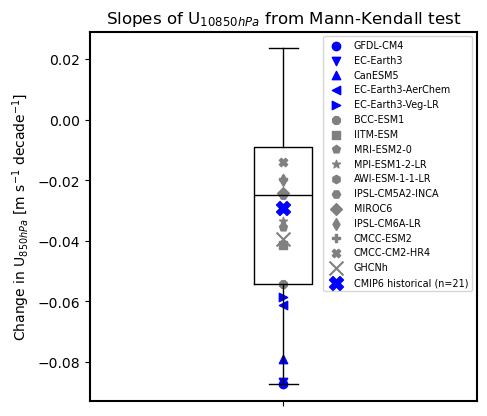

In [112]:
results = dict(
    source_id=[],
    trend=[],
    h=[],
    p=[],
    z=[],
    Tau=[],
    s=[],
    var_s=[],
    slope=[],
    intercept=[]
)
for source_id in ds.source_id.to_numpy():
    model_da = spatial_avg.sel(source_id=source_id)
    wind = model_da.to_numpy()
    res = mk.original_test(wind, alpha=0.05)
    results['source_id'].append(source_id)
    results['trend'].append(res.trend)
    results['h'].append(res.h)
    results['p'].append(res.p)
    results['z'].append(res.z)
    results['Tau'].append(res.Tau)
    results['s'].append(res.s)
    results['var_s'].append(res.var_s)
    results['slope'].append(res.slope)
    results['intercept'].append(res.intercept)

df_mk = pl.from_dict(results).sort('slope')
# Change filename
# df_mk.write_csv(os.path.join(DATA_DIR, 'mann-kendall-tests/CMIP6historical_day_yearly.csv'), float_precision=5)
slopes = df_mk['slope'].to_numpy()*10
trends = df_mk['trend'].to_numpy()
source_ids = df_mk['source_id'].to_numpy()
filled_markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'][:len(slopes)]
fig, ax = plt.subplots(figsize=(5, 4.8))
box_plot = ax.boxplot(slopes, showfliers=False)
box_plot['medians'][0].set_color('black')
for slope, trend, source_id, marker in zip(slopes, trends, source_ids, filled_markers):
    if trend == 'increasing':
        ax.scatter(1, slope, marker=marker, color='r', label=source_id)
    elif trend == 'no trend': 
        ax.scatter(1, slope, marker=marker, color='gray', label=source_id)
    elif trend == 'decreasing':
        ax.scatter(1, slope, marker=marker, color='blue', label=source_id)
# Now plot station data
ax.scatter(1, result_s.slope*10, marker='x', color='gray', s=100, label='GHCNh')
# Now plot CMIP6 historical data
ax.scatter(1, result_a.slope*10, marker='X', color='blue', s=100, label=f'CMIP6 historical (n={len(ds.source_id)})')
ax.legend()
ax.set_xticklabels('')
ax.set_ylabel('Change in U$_{850hPa}$ [m s$^{-1}$ decade$^{-1}$]')
ax.set_title('Slopes of U$_{10850hPa}$ from Mann-Kendall test')
plt.legend(fontsize='x-small')
for spine in ax.spines.values():
        spine.set_linewidth(1.5)
# Change filepath
# plt.savefig(os.path.join(FIG_DIR, 'GHCNh_CMIP6historical_cna_yearly_mk_boxplot.png'), dpi=300)
plt.show()